# 금융데이터베이스 Group 7 기말프로젝트

* 20249032	곽기은	klutzduck@kaist.ac.kr
* 20249124	김태훈	thk24@kaist.ac.kr
* 20249197	서승건	seanseo@kaist.ac.kr
* 20249366	장우석	expressj@kaist.ac.kr
* 20249402	조영민	youngmin.cho@kaist.ac.kr
* 20249459	홍성수	seongsu.hong@kaist.ac.kr

In [16]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import wbgapi as wb

from statsmodels.tsa.stattools import adfuller
from pandas.tseries.offsets import MonthEnd, YearEnd
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from pathlib import Path
from PublicDataReader import Ecos
from PublicDataReader import Fred

# https://ecos.bok.or.kr/api/#/DevGuide/DevSpeciflcation
# SSL 보안 장비 등으로 인해 SSL Verification Error가 발생할 경우에 대비해서 requests.get할 때 verify = False하고, warning을 무시하도록 설정한다.
# SSL Verification을 끈다.
import warnings
warnings.filterwarnings(action = 'ignore')

In [13]:
# 한국은행 API를 사용하기 위한 인증정보를 설정한다.
BOK_API_URL = 'https://ecos.bok.or.kr/api'
BOK_API_KEY = 'W2HQL3IHAD2LKU409JDH'

FRED_API_KEY = 'c91b752313c5c426691c24ffbde0246e'

apiEcos = Ecos(BOK_API_KEY)
apiFred = Fred(FRED_API_KEY)

## 환율 변화율을 예측하기

### IMF 이전 환율정책:

* IMF 외환위기 이전 한국은 '관리변동환율제'를 채택하고 있었습니다.
* 이 제도 하에서 정부는 환율의 일일 변동폭을 제한하고, 외환시장에 직접 개입하여 환율을 관리했습니다.


### IMF 이후 환율정책:

* 1997년 12월 IMF 구제금융을 받으면서 한국은 '자유변동환율제'로 전환했습니다.
* 이 제도에서는 원칙적으로 시장의 수요와 공급에 따라 환율이 결정됩니다.
* 정부의 직접적인 시장 개입은 크게 줄어들었습니다

### 아베노믹스 (2012년 ~ ) : 2012년 12월 26일

* 영향력: 매우 큼
* 지속기간: 장기적 (수년간 지속)
* 직접성: 엔화 환율에 직접적인 영향
* 의도성: 의도적인 엔화 약세 정책

### 아베노믹스는 일본 경제 회복을 위해 의도적으로 엔화 가치를 낮추는 정책을 포함했습니다. 
### 이로 인해 엔화 가치가 급격히 하락했고, 원/엔 환율에 지속적이고 큰 영향을 미쳤습니다.

## Convert to monthly observations
### End-of-month observation

In [15]:
df_xr = apiEcos.get_statistic_search(통계표코드="731Y001", 통계항목코드1="0000002", 주기="D", 검색시작일자="20121226", 검색종료일자="20240809")
df_xr = df_xr[['시점','값']]
df_xr.rename(columns = {'시점' : 'date', '값' : 'KRW/JPY'}, inplace=True)
df_xr['date'] = pd.to_datetime(df_xr['date'])
df_xr['KRW/JPY'] = df_xr['KRW/JPY'].astype(float)
df_xr = df_xr.set_index('date')
df_monthly = df_xr.resample('ME').last()
df_monthly['ret'] = df_monthly['KRW/JPY'].pct_change() * 100
df_monthly = df_monthly.dropna()
df_monthly.head(3)

,KRW/JPY,ret
date,,
2013-01-31,1188.47,-4.731864
2013-02-28,1176.20,-1.032420
2013-03-31,1180.13,0.334127


In [10]:
X = df_monthly.iloc[:-1]['ret']
X = sm.add_constant(X)
Y = df_monthly.iloc[1:]['ret']

sm.OLS(Y, X.values).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                   0.03353
Date:                Sun, 11 Aug 2024   Prob (F-statistic):              0.855
Time:                        13:27:55   Log-Likelihood:                -319.94
No. Observations:                 139   AIC:                             643.9
Df Residuals:                     137   BIC:                             649.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1469      0.207     -0.709      0.480      -0.557       0.263
x1            -0.0156      0.085     -0.183      0.855      -0.183       0.152
==============================================================================
Omnibus:                        0.974   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.614   Jarque-Bera (JB):                0.908
Skew:                           0.196   Prob(JB):                        0.635
Kurtosis:                       2.940   Cond. No.                         2.45
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

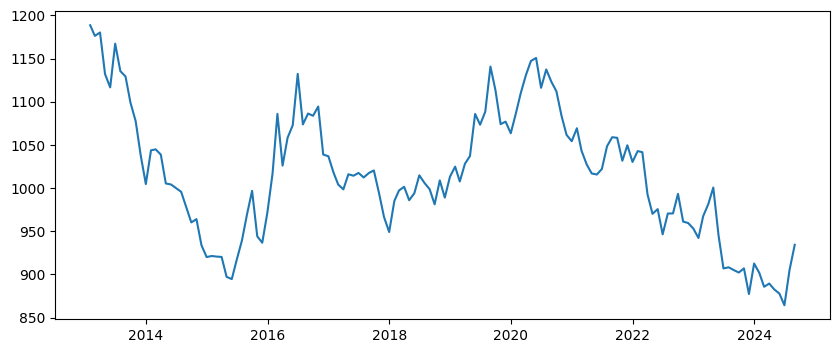

In [11]:
plt.rcParams['figure.figsize'] = (10, 4)
plt.plot(df_monthly['KRW/JPY'])
plt.show()

In [46]:
df_real_xr = wb.data.DataFrame('PA.NUS.PPPC.RF', numericTimeKeys=True)
df_real_xr_kor = df_real_xr.loc['KOR'].to_frame()
df_real_xr_kor = df_real_xr_kor.dropna()
df_real_xr_kor['KOR'] = df_real_xr_kor['KOR'].astype(float)
df_real_xr_kor['date'] = pd.to_datetime(df_real_xr_kor.index.astype(str)) + YearEnd()
df_real_xr_kor = df_real_xr_kor.set_index('date')
df_real_xr_kor.columns = ['KOR Real XR']
df_real_xr_kor.head(3)

,KOR Real XR
date,
1990-12-31,0.791111
1991-12-31,0.806041
1992-12-31,0.797916


In [49]:
df_real_xr_jpn = df_real_xr.loc['JPN'].to_frame()
df_real_xr_jpn = df_real_xr_jpn.iloc[3:]
df_real_xr_jpn = df_real_xr_jpn.dropna()
df_real_xr_jpn['JPN'] = df_real_xr_jpn['JPN'].astype(float)
df_real_xr_jpn['date'] = pd.to_datetime(df_real_xr_jpn.index.astype(str)) + YearEnd()
df_real_xr_jpn = df_real_xr_jpn.set_index('date')
df_real_xr_jpn.columns = ['JPN Real XR']
df_real_xr_jpn.head(3)

,JPN Real XR
date,
1990-12-31,1.295738
1991-12-31,1.386324
1992-12-31,1.465824


In [ ]:
# 기존의 KOR와 JPN 데이터프레임을 합칩니다
df_combined = pd.concat([df_real_xr_kor, df_real_xr_jpn], axis = 1)

# KRW/JPY 실질환율 계산
# KRW/USD를 JPY/USD로 나눈다.
df_combined['KRW/JPY Real XR'] = df_combined['KOR Real XR'] / (df_combined['JPN Real XR'])

# 결과 확인
df_combined.tail(3)

In [ ]:
df_real_xr = df_combined['KRW/JPY Real XR']

In [ ]:
plt.plot(df_real_xr)
plt.show()

## Overlapping monthly forecasts

In [ ]:
df_monthly = df_monthly.drop('ret', axis = 1)
df_merged = df_monthly.join(df_real_xr)
# ffill - forward fill
# bfill - backward fill
df_merged['KRW/JPY Real XR'] = df_merged['KRW/JPY Real XR'].ffill()

df_merged['ann_ret'] = df_merged['KRW/JPY'].pct_change(periods = 12) * 100

df_merged['F12.ann_ret'] = df_merged['ann_ret'].shift(-12)

df_merged.head(15)


### Use OLS to fit the forecast model

In [ ]:
df = df_merged[['KRW/JPY Real XR', 'F12.ann_ret']]
df = df.dropna()

In [ ]:
X = df['KRW/JPY Real XR']
X = sm.add_constant(X)
Y = df['F12.ann_ret']

sm.OLS(Y, X).fit().summary()

## Real XR 대신 PPP XR 활용하기

In [ ]:
def load_world_bank_data(filepath, country, column):
    df = pd.read_excel(filepath, sheet_name = 'Data', skiprows = 3)

    df = df.set_index('Country Code')
    df = df.loc[country].to_frame()
    df = df.iloc[3:]
    df = df.dropna()
    df = df.astype(float)
    
    df['date'] = pd.to_datetime(df.index) + YearEnd()
    df = df.set_index('date')
    df.columns = [column]
    
    return df

In [ ]:
df_ppp_xr_kor = load_world_bank_data(Path('data/world_ppp_xr.xls'), 'KOR', 'PPP XR')
df_ppp_xr_jpn = load_world_bank_data(Path('data/world_ppp_xr.xls'), 'JPN', 'PPP XR')

In [ ]:
df_ppp_combined = pd.concat([df_ppp_xr_kor, df_ppp_xr_jpn], axis = 1)
df_ppp_combined.columns = ['KOR PPP XR', 'JPN PPP XR']
df_ppp_combined['KRW/JPY PPP XR'] = df_ppp_combined['KOR PPP XR'] / (df_ppp_combined['JPN PPP XR'])
df_ppp_xr = df_ppp_combined.drop(['KOR PPP XR', 'JPN PPP XR'], axis = 1)

In [ ]:
df_ppp_xr.head(3)

### Merge with monthly observations

In [ ]:
df_merged = df_monthly.join(df_real_xr)
df_merged = df_merged.join(df_ppp_xr)
df_merged.head(3)

### Compute Real XR

In [ ]:
df_merged['KRW/JPY PPP XR'] = df_merged['KRW/JPY PPP XR'].ffill()
df_merged.head(3)

In [ ]:
df_merged['New Real XR'] = df_merged['KRW/JPY PPP XR'] / df_merged['KRW/JPY'] * 100
df_merged.tail(3)

In [ ]:
df_merged['KRW/JPY Real XR'] = df_merged['KRW/JPY Real XR'].ffill()

In [ ]:
plt.plot(df_merged['New Real XR'], label='New Real XR')
plt.plot(df_merged['KRW/JPY Real XR'].shift(-12), label='World Bank')
plt.legend()
plt.show()

## Compute annual XR return

In [ ]:
df_merged['ann_ret'] = df_merged['KRW/JPY'].pct_change(periods = 12) * 100
df_merged['F12.ann_ret'] = df_merged['ann_ret'].shift(-12)
df_merged.head(5)

### Use OLS to fit the forecast model

In [ ]:
df = df_merged[['New Real XR', 'F12.ann_ret']]
df = df.dropna()

X = df['New Real XR']
X = sm.add_constant(X)
Y = df['F12.ann_ret']

results = sm.OLS(Y,X).fit()
results.summary()

### Predict XR

In [ ]:
last_obs = df_merged.iloc[-1]
last_obs

In [ ]:
last_xr = last_obs['KRW/JPY']
last_real_xr = last_obs['New Real XR']

In [ ]:
last_xr

In [ ]:
last_real_xr

### OLS 결과 그대로 사용하여 예측

In [ ]:
#exogeneous variables
exog = [1, last_real_xr]
results.predict(exog = exog)

### Confidence Interval

In [ ]:
for alpha in [0.05, 0.25, 0.50]:
    prstd, iv_l, iv_u = wls_prediction_std(results, exog = exog, alpha = alpha)
    
    print('Confidence interval at alpha = {:.2f}: {:.2f} ~ {:.2f}'.format(
        alpha,
        iv_l[0],
        iv_u[0],
    ))

### 환율 예측하기

In [ ]:
pred_ret = results.predict(exog = exog)
last_xr * (1 + pred_ret[0] / 100)

In [ ]:
for alpha in [0.05, 0.25, 0.50]:
    prstd, iv_l, iv_u = wls_prediction_std(results, exog = exog, alpha = alpha)
    
    print('Confidence interval at alpha = {:.2f}: {:.2f} ~ {:.2f}'.format(
        alpha,
        last_xr * (1 + iv_l[0] / 100),
        last_xr * (1 + iv_u[0] / 100),
    ))

## 추가 지표 획득

In [ ]:
def fetch_bok_data(service_code, stat_code=None, item=None):
    url = f"{BOK_API_URL}/{service_code}/{BOK_API_KEY}/json/kr/1/100000"
    
    if item is not None:
        url += "/{}/{}/{}/{}/{}".format(item['STAT_CODE'], item['CYCLE'], item['START_TIME'], item['END_TIME'], item['ITEM_CODE'])
        
        if type(item['ITEM_CODE2']) is str:
            url += f"/{item['ITEM_CODE2']}"
        
    elif stat_code is not None:
        url += f"/{stat_code}"
    
    print(url)
    
    resp = requests.get(url, verify = False)
    results = resp.json()
    rows = results[service_code]['row']
    df = pd.DataFrame(rows)
    
    return df

In [ ]:
TARGET_STAT_CODES = [
    '731Y001',  # 3.1.1.1. 주요국 통화의 대원화환율
    '902Y008',  # 9.1.2.2. 국제 주요국 소비자물가지수
    '902Y009',  # 9.1.3.1. 국제 주요국 경상수지
    '902Y015',  # 9.1.4.1. 국제 주요국 경제성장률
    '902Y016',  # 9.1.4.2. 국제 주요국 국내총생산(GDP)
    '902Y023',  # 9.1.6.1. 주요국제금리
    '817Y002',  # 1.3.2.1. 시장금리(일별)
    '732Y001',  # 3.5. 외환보유액
]

In [ ]:
dfs = []

for stat_code in TARGET_STAT_CODES:
    df = fetch_bok_data('StatisticItemList', stat_code = stat_code)
    
    dfs.append(df)

In [ ]:
df_item_codes = pd.concat(dfs, axis = 0)

In [ ]:
df_item_codes.to_excel(Path('data/bok_item_codes.xlsx'), index = False)

In [ ]:
df_item_codes = df_item_codes.set_index(['STAT_CODE', 'ITEM_CODE', 'CYCLE'])

### Download data values

In [ ]:
data_download_list = pd.read_excel(Path('data/bok_data_download_list_jpy.xlsx'))

In [ ]:
data_download_list

In [ ]:
#iterate over row
for idx, row in data_download_list.iterrows():
    name = row['name']
    print(f"Downloading {name}...")
    
    idx = (row.STAT_CODE, row.ITEM_CODE, row.CYCLE)
    item = df_item_codes.loc[idx]
    item ={**item, **row}
    
    df = fetch_bok_data('StatisticSearch', item = item)
    df = df[['TIME', 'DATA_VALUE']]
    
    if row['CYCLE'] == 'D':
        df['date'] = pd.to_datetime(df['TIME'])
    
    elif row['CYCLE'] == 'M':
        df['date'] = pd.to_datetime(df['TIME'], format = '%Y%m') + MonthEnd()
    
    elif row['CYCLE'] == 'Q':
        df['year'] = df['TIME'].str[:4]
        df['month'] = df['TIME'].str[-1].astype(int) * 3
        df['day'] = 1
        df['date'] = pd.to_datetime(df[['year', 'month', 'day']]) + MonthEnd()
    
    elif row['CYCLE'] == 'A':
        df['date'] = pd.to_datetime(df['TIME']) + YearEnd()
    
    else:
        raise RuntimeError()
        
    df = df[['date','DATA_VALUE']]
    df = df.rename(columns={'DATA_VALUE': name, })
    
    df[name] = df[name].astype(float)
    
    df.to_excel(Path(f"data/{name}.xlsx"), index = False)
    
print('** Completed!! **')

## BOK 파일 불러오기

In [ ]:
filenames = [
    'krw_jpy_xr',
    'current_account_korea',
    'current_account_us',
    'current_account_jp',
    'gdp_korea',
    'gdp_us',
    'gdp_jp',
    'gdp_growth_korea',
    'gdp_growth_jp',
    'gdp_growth_us',
    'cpi_korea',
    'cpi_jp',
    'cpi_us',
    'int_rate_korea',
    'int_rate_jp',
    'int_rate_us',
    'foreign_reserves',
]

In [ ]:
dfs = []

for fname in filenames:
    print(f"Loding {fname}....")
    
    df = pd.read_excel(Path(f"data/{fname}.xlsx"))
    df = df.set_index('date')
    
    if fname in ['gdp_growth_korea',
        'gdp_growth_jp',
        'gdp_growth_us',
        'current_account_us',
        'current_account_jp',
        'current_account_korea',
                ]:
        df[fname] = df[fname].rolling(4).sum()
    
    dfs.append(df)
    
print('** Completed **')

### World Bank 데이터로 계산했었던 KOR/JPY PPP XR 불러오기

In [ ]:
dfs.append(df_ppp_xr)

## Merge the datasets

In [ ]:
df_merged = pd.concat(dfs, axis = 1)
df_merged = df_merged.resample('ME').last()
df_merged = df_merged.ffill()
df_merged.loc['2010-01-01':].head()

# >>반영할 수 있는 지표들

### 환율 수익률

In [ ]:
df_merged['ann_ret'] = df_merged['KRW/JPY'].pct_change(periods = 12) * 100
df_merged['F12.ann_ret'] = df_merged['ann_ret'].shift(-12)

### Real XR

In [ ]:
df_merged['real_xr'] = df_merged['KRW/JPY PPP XR'] / df_merged['KRW/JPY']

### Current accounts(경상수지) relative to GDP

In [ ]:
df_merged['ca_gdp_korea'] = df_merged['current_account_korea'] / df_merged['gdp_korea'] * 100
df_merged['ca_gdp_jp'] = df_merged['current_account_jp'] / df_merged['gdp_jp'] * 100

In [ ]:
#stationary process
plt.plot(df_merged.loc['2012-12-26':]['ca_gdp_korea'], label = 'ca_gdp_korea')
plt.plot(df_merged.loc['2012-12-26':]['ca_gdp_jp'], label = 'ca_gdp_jp')
plt.legend()
plt.show()

### GDP Growth

In [ ]:
df_merged['gdp_growth_korea2'] = df_merged['gdp_korea'].pct_change(periods = 12) * 100
df_merged['gdp_growth_jp2'] = df_merged['gdp_jp'].pct_change(periods = 12) * 100

### Inflation (YoY, Y/Y)

In [ ]:
df_merged['infl_korea'] = df_merged['cpi_korea'].pct_change(periods = 12) * 100
df_merged['infl_jp'] = df_merged['cpi_jp'].pct_change(periods = 12) * 100

### 상대적 인플레이션 & 금리 차이

In [ ]:
df_merged['infl_diff'] = df_merged['infl_korea'] - df_merged['infl_jp']
df_merged['int_rate_diff'] = df_merged['int_rate_korea'] - df_merged['int_rate_jp']

### GDP 대비 외환보유액 및 증가율

In [ ]:
df_merged['reserves_to_gdp'] = df_merged['foreign_reserves'] / df_merged['gdp_korea'] / 1000 * 100
df_merged['reserves_growth'] = df_merged['foreign_reserves'].pct_change(periods = 12) * 100

### 필요한 컬럼만 남김

In [ ]:
df_sample = df_merged[[
    'F12.ann_ret', 'real_xr',
    'ca_gdp_korea', 'ca_gdp_jp',
    'gdp_growth_korea', 'gdp_growth_jp',
    'infl_diff', 'int_rate_diff',
    'reserves_to_gdp', 'reserves_growth'
]]

In [ ]:
df_sample = df_sample.dropna()
df_sample = df_sample.loc['1998-12-31':]

In [ ]:
df_sample.head(3)

In [ ]:
corr = df_sample.corr()
# triu = upper triangle
mask = np.triu(np.ones_like(corr))
cmap=sns.diverging_palette(230, 20, as_cmap = True)
mask=np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask = mask, cmap = cmap, vmin = -1, vmax = 1)
plt.show()

In [ ]:
X = df_sample
X = sm.add_constant(X)
Y = df_sample['F12.ann_ret']

sm.OLS(Y,X).fit().summary()

## Fetch Additional Datasources

In [ ]:
# Collect Item Codes
stat_codes = fetch_bok_data('StatisticTableList')
stat_codes

In [ ]:
TARGET_STAT_CODES = {
    '731Y001': 'krw_xr', # 3.1.1.1. 주요국 통화의 대원화환율 from 서울외국환중개 - Daily
    '902Y006': 'policy_ir', # 9.1.1.3. 국제 주요국 중앙은행 정책금리 from BIS - Monthly
    '902Y004': 'mon_base', # 9.1.1.1. 국제 주요국 본원통화 from IMF - Monthly
    '902Y005': 'mon_broad', # 9.1.1.2. 국제 주요국 광의통화 from IMF - Monthly
    '902Y012': 'export', # 9.1.3.4. 국제 주요국 수출(통관기준) from IMF - Monthly
    '902Y013': 'import', # 9.1.3.5. 국제 주요국 수입(통관기준) from IMF - Monthly
    '902Y014': 'foreign_reserve', # 9.1.3.6. 국제 주요국 외환보유액 from IMF - Monthly
    '902Y002': 'stock', # 9.1.6.2. 국제 주요국 주가지수 from OECD - Monthly
    '902Y020': 'ipi', # 9.1.5.1. 국제 주요국 산업생산지수(계절변동조정) from OECD
    '902Y021': 'unemployment', # 9.1.5.2. 국제 주요국 실업률(계절변동조정) from OECD - Monthly
    '902Y016': 'gdp', # 9.1.4.2. 국제 주요국 국내총생산(GDP) from OECD - Annual
}

In [ ]:
dfs = []

for stat_code in TARGET_STAT_CODES.keys() :
    df = fetch_bok_data('StatisticItemList', stat_code=stat_code) # 통계 세부항목 목록
    dfs.append(df)

In [ ]:
df_items = pd.concat(dfs, axis=0)
#df_items = df_items.set_index(['STAT_CODE', 'ITEM_CODE', 'CYCLE'])

In [ ]:
idx01 = df_items['STAT_CODE'] == '731Y001'
idx02 = df_items['ITEM_CODE'] == '0000002'

idx11 = df_items['ITEM_NAME'].str.find('한국') >= 0
idx12 = df_items['ITEM_NAME'].str.find('일본') >= 0
idx13 = df_items['CYCLE'] == 'M'

idx21 = df_items['STAT_CODE'] == '902Y016'

df_items = df_items.loc[(idx01 * idx02) + ((idx11 + idx12) * idx13) + ((idx11 + idx12) * idx21)]
df_items

In [ ]:
def fetch_bok_data(service_code, stat_code=None, item=None) :
    url = f"{BOK_API_URL}/{service_code}/{BOK_API_KEY}/json/kr/1/100000"

    if item is not None: 
        url += "/{}/{}/{}/{}/{}".format(item['STAT_CODE'], item['CYCLE'], item['START_TIME'], item['END_TIME'], item['ITEM_CODE'])
                
    elif stat_code : 
        url += f"/{stat_code}"
        
    print(url)
    resp = requests.get(url)
    results = resp.json()
    rows = results[service_code]['row']
    df = pd.DataFrame(rows)

    return df

In [ ]:
# iterate over rows
for idx, row in df_items.iterrows():
    name = TARGET_STAT_CODES.get(row['STAT_CODE']) + '_' + row['ITEM_CODE'].lower()
    print(f"Downloading {name}...")

    df = fetch_bok_data('StatisticSearch', item=row) # 통계 조회조건 설정
    df = df[['TIME', 'DATA_VALUE']]

    if row['CYCLE'] == 'D' :
        df['date'] = pd.to_datetime(df['TIME'])
        
    elif row['CYCLE'] == 'M' :
        df['date'] = pd.to_datetime(df['TIME'], format='%Y%m') + MonthEnd()
        
    elif row['CYCLE'] == 'Q' :
        df['year'] = df['TIME'].str[:4]
        df['month'] = df['TIME'].str[-1].astype(int) * 3
        df['day'] = 1
        df['date'] = pd.to_datetime(df[['year', 'month', 'day']]) + MonthEnd()
        
    elif row['CYCLE'] == 'A' :
        df['date'] = pd.to_datetime(df['TIME']) + YearEnd()
        
    else :
        raise RuntimeError()
    
    df = df[['date', 'DATA_VALUE']]
    df = df.rename(columns={'DATA_VALUE': name})
    df[name] = df[name].astype(float)

    df.to_excel(f"data/{name}.xlsx", index=False)
    print()

print("** Completed!! **")

In [ ]:
filenames = [
    'krw_xr_0000002',
    'policy_ir_kr',
    'policy_ir_jp',
    'mon_base_kr',
    'mon_base_jp',
    'mon_broad_kr',
    'mon_broad_jp',
    'export_kr',
    'export_jp',
    'import_kr',
    'import_jp',
    'foreign_reserve_kr',
    'foreign_reserve_jp',
    'stock_kor',
    'stock_jpn',
    'ipi_kor',
    'ipi_jpn',
    'unemployment_kor',
    'unemployment_jpn',
    'gdp_kor',
    'gdp_jpn',
    'wui_kor',
    'wui_jpn',
]

In [ ]:
dfs = []

for fname in filenames :
    print(f"Loading {fname}...")

    df = pd.read_excel(f"data/{fname}.xlsx")
    df = df.set_index('date')

    dfs.append(df)

print("** Completed! **")
dfs

In [ ]:
df_merged = pd.concat(dfs, axis=1)
df_merged.rename(columns={'krw_xr_0000002': 'krw_jpy_xr'}, inplace=True)
df_merged = df_merged.sort_index()
df_merged.head(3)

In [ ]:
df_merged = df_merged['2012-12-31':]
df_merged = df_merged.resample('ME').last()
df_merged = df_merged.ffill()
df_merged.head(3)

In [ ]:
# Y. F12.ann_ret
df_merged['ann_ret'] = df_merged['krw_jpy_xr'].pct_change(periods=12) * 100
df_merged['F12.ann_ret'] = df_merged['ann_ret'].shift(-12)
df_merged[['ann_ret', 'F12.ann_ret']]

In [ ]:
# X1. 한일 정책금리 차이
df_merged['policy_ir_diff'] = df_merged['policy_ir_kr'] - df_merged['policy_ir_jp']
df_merged['policy_ir_diff_rt'] = df_merged['policy_ir_diff'].pct_change(periods=12) * 100

plt.rcParams['figure.figsize'] = (10, 4)

plt.plot(df_merged[['policy_ir_kr', 'policy_ir_jp', 'policy_ir_diff']], label = ['policy_ir_kr', 'policy_ir_jp', 'policy_ir_diff'])
plt.legend()
plt.show()

In [ ]:
adf_result = adfuller(df_merged['policy_ir_diff'])
adf_result[1] # adf_result[1] < 0.05이면 stationary

In [ ]:
plt.plot(df_merged[['policy_ir_diff_rt']])
plt.show()

In [ ]:
adf_result = adfuller(df_merged['policy_ir_diff_rt'].dropna())
adf_result[1] # adf_result[1] < 0.05이면 stationary

In [ ]:
# X2. 한일 통화승수 차이
df_merged['mon_multiplier_kr'] = df_merged['mon_broad_kr'] / df_merged['mon_base_kr']
df_merged['mon_multiplier_jp'] = df_merged['mon_broad_jp'] / df_merged['mon_base_jp']
df_merged['mon_multiplier_diff'] = df_merged['mon_multiplier_kr'] - df_merged['mon_multiplier_jp']
df_merged['mon_multiplier_diff_rt'] = df_merged['mon_multiplier_diff'].pct_change(periods=12) * 100

plt.plot(df_merged[['mon_multiplier_kr', 'mon_multiplier_jp', 'mon_multiplier_diff']], label = ['mon_multiplier_kr', 'mon_multiplier_jp', 'mon_multiplier_diff'])
plt.legend()
plt.show()

In [ ]:
adf_result = adfuller(df_merged['mon_multiplier_diff'])
adf_result[1] # adf_result[1] < 0.05이면 stationary

In [ ]:
plt.plot(df_merged[['mon_multiplier_diff_rt']])
plt.show()

In [ ]:
adf_result = adfuller(df_merged['mon_multiplier_diff_rt'].dropna())
adf_result[1] # adf_result[1] < 0.05이면 stationary

In [ ]:
# X3. 한일 무역수지 차이
df_merged['trade_balance_kr'] = df_merged['export_kr'] - df_merged['import_kr']
df_merged['trade_balance_jp'] = df_merged['export_jp'] - df_merged['import_jp']
df_merged['trade_balance_diff'] = df_merged['trade_balance_kr'] - df_merged['trade_balance_jp']
plt.plot(df_merged[['trade_balance_kr', 'trade_balance_jp', 'trade_balance_diff']], label = ['trade_balance_kr', 'trade_balance_jp', 'trade_balance_diff'])
plt.legend()
plt.show()

In [ ]:
adf_result = adfuller(df_merged['trade_balance_diff'])
adf_result[1] # adf_result[1] < 0.05이면 stationary

In [ ]:
# X4. 한일 GDP 대비 외환보유액 차이
df_merged['foreign_reserve_to_gdp_kr'] = df_merged['foreign_reserve_kr'] / df_merged['gdp_kor'] * 100
df_merged['foreign_reserve_to_gdp_jp'] = df_merged['foreign_reserve_jp'] / df_merged['gdp_jpn'] * 100
df_merged['foreign_reserve_to_gdp_diff'] = df_merged['foreign_reserve_to_gdp_kr'] - df_merged['foreign_reserve_to_gdp_jp']
df_merged['foreign_reserve_to_gdp_diff_rt'] = df_merged['foreign_reserve_to_gdp_diff'].pct_change(periods=12) * 100

plt.plot(df_merged[['foreign_reserve_to_gdp_diff']])
plt.show()

In [ ]:
adf_result = adfuller(df_merged['foreign_reserve_to_gdp_diff'])
adf_result[1] # adf_result[1] < 0.05이면 stationary

In [ ]:
plt.plot(df_merged[['foreign_reserve_to_gdp_diff_rt']])
plt.show()

In [ ]:
adf_result = adfuller(df_merged['foreign_reserve_to_gdp_diff_rt'].dropna())
adf_result[1] # adf_result[1] < 0.05이면 stationary

In [ ]:
# X5. 한일 주가지수 비율
df_merged['stock_ratio'] = df_merged['stock_kor'] / df_merged['stock_jpn']

plt.plot(df_merged[['stock_ratio']])
plt.show()

In [ ]:
adf_result = adfuller(df_merged['stock_ratio'].dropna())
adf_result[1] # adf_result[1] < 0.05이면 stationary

In [ ]:
# X6. 한일 산업생산지수(IPI) 차이
df_merged['ipi_diff'] = df_merged['ipi_kor'] - df_merged['ipi_jpn']
df_merged['ipi_diff_rt'] = df_merged['ipi_diff'].pct_change(periods=12) * 100

plt.plot(df_merged[['ipi_diff']])
plt.show()

In [ ]:
adf_result = adfuller(df_merged['ipi_diff'])
adf_result[1] # adf_result[1] < 0.05이면 stationary

In [ ]:
plt.plot(df_merged[['ipi_diff_rt']])
plt.show()

In [ ]:
adf_result = adfuller(df_merged['ipi_diff_rt'].dropna())
adf_result[1] # adf_result[1] < 0.05이면 stationary

In [ ]:
# X7. 한일 실업률 차이
df_merged['unemployment_diff'] = df_merged['unemployment_kor'].diff(1) - df_merged['unemployment_jpn'].diff(1)

plt.plot(df_merged[['unemployment_diff']])
plt.show()

In [ ]:
adf_result = adfuller(df_merged['unemployment_diff'].dropna())
adf_result[1] # adf_result[1] < 0.05이면 stationary

In [ ]:
# X8. 한일 World Uncertainty Index(IMF) 차이
plt.plot(df_merged[['wui_kor', 'wui_jpn']], label = ['wui_kor','wui_jpn'])
plt.legend()
plt.show()

In [ ]:
df_merged['wui_kor_ravg'] = df_merged['wui_kor'].rolling(4).mean()
df_merged['wui_jpn_ravg'] = df_merged['wui_jpn'].rolling(4).mean()
df_merged['wui_diff'] = df_merged['wui_kor_ravg'] - df_merged['wui_jpn_ravg']

plt.plot(df_merged[['wui_kor_ravg', 'wui_jpn_ravg', 'wui_diff']], label = ['wui_kor_ravg', 'wui_jpn_ravg', 'wui_diff'])
plt.legend()
plt.show()

In [ ]:
adf_result = adfuller(df_merged['wui_diff'].dropna())
adf_result[1] # adf_result[1] < 0.05이면 statioanary

In [ ]:
# Stationary로 변환된 변수들을 모아보자.
df_added = df_merged[[
    'policy_ir_diff_rt',               # X1. 한일 정책금리 차이
    'mon_multiplier_diff_rt',          # X2. 한일 통화승수 차이
    'trade_balance_diff',              # X3. 한일 무역수지 차이
    'foreign_reserve_to_gdp_diff_rt',  # X4. 한일 GDP 대비 외환보유액 차이
    'stock_ratio',                     # X5. 한일 주가지수 비율
    'ipi_diff_rt',                     # X6. 한일 산업생산지수(IPI) 차이
    'unemployment_diff',               # X7. 한일 실업률 차이
    'wui_diff',                        # X8. 한일 World Uncertainty Index(IMF) 차이
    'F12.ann_ret'                      # Y. 수익률(12개월 전)
]]
df_added = df_added.dropna()
df_added.head(15), df_added.tail(15)

In [ ]:
### Use OLS to fit the forecast model
Y = df_added['F12.ann_ret']
X = df_added.drop('F12.ann_ret', axis=1)
X = sm.add_constant(X)

sm.OLS(Y, X).fit().summary()

In [ ]:
# p-value 낮은 변수 drop
X = X.drop(
    [
        'mon_multiplier_diff_rt',
        'trade_balance_diff',
        'foreign_reserve_to_gdp_diff_rt',
        'ipi_diff_rt',
        'unemployment_diff'
    ],
    axis=1
)

sm.OLS(Y, X).fit().summary()